# Site planning, Oct 2025
This notebook projects the locations of our four sites on Flask using satellite derived velocities. It also computes the midpoint of the four sites and the midpoint of sites 2 and 3.

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray


In [2]:
gdf = gpd.read_file("/Users/jkingslake/Documents/projects/current_projects/AntPen_NSF_NERC/fieldwork/recce_planning_oct25/site_names.shp")

In [3]:
gdf.set_index('Site', inplace=True)
def point(site):
    return (gdf.loc[site].geometry.x, gdf.loc[site].geometry.y)

In [24]:
import numpy as np

def line_intersection(p1, p2, p3, p4):
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    x4, y4 = p4

    # Compute denominators
    denom = (x1 - x2)*(y3 - y4) - (y1 - y2)*(x3 - x4)

    # Intersection point
    px = ((x1*y2 - y1*x2)*(x3 - x4) - (x1 - x2)*(x3*y4 - y3*x4)) / denom
    py = ((x1*y2 - y1*x2)*(y3 - y4) - (y1 - y2)*(x3*y4 - y3*x4)) / denom

    return px, py
mid_point_old = line_intersection(point('Site 1'), point('Site 4'), point('Site 2'), point('Site 3'))
mid_point_old

(-2371482.665160681, 1225480.6343778777)

In [10]:
V = rioxarray.open_rasterio('/Users/jkingslake/Documents/projects/current_projects/AntPen_NSF_NERC/remote sensing/velocities/multiyear/20141125_20250805/V_median_20141125_20250805_200m_timefiltered.tif').load()
U = rioxarray.open_rasterio('/Users/jkingslake/Documents/projects/current_projects/AntPen_NSF_NERC/remote sensing/velocities/multiyear/20141125_20250805/U_median_20141125_20250805_200m_timefiltered.tif').load()
S = rioxarray.open_rasterio('/Users/jkingslake/Documents/projects/current_projects/AntPen_NSF_NERC/remote sensing/velocities/multiyear/20141125_20250805/S_median_20141125_20250805_200m_timefiltered.tif').load()

In [46]:
U

<xarray.DataArray (band: 1, y: 6969, x: 6393)> Size: 178MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]],
      shape=(1, 6969, 6393), dtype=float32)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 51kB -2.859e+06 -2.858e+06 ... -1.58e+06 -1.58e+06
  * y            (y) float64 56kB 1.894e+06 1.894e+06 ... 5.003e+05 5.001e+05
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_SOFTWARE:  MATLAB 9.12, Mapping Toolbox 5.3
    AREA_OR_POINT:     Area
    _FillValue:        -9999.0
    scale_factor:      1.0
    add_offset:        0.0

Text(0.5, 1.0, 'U')

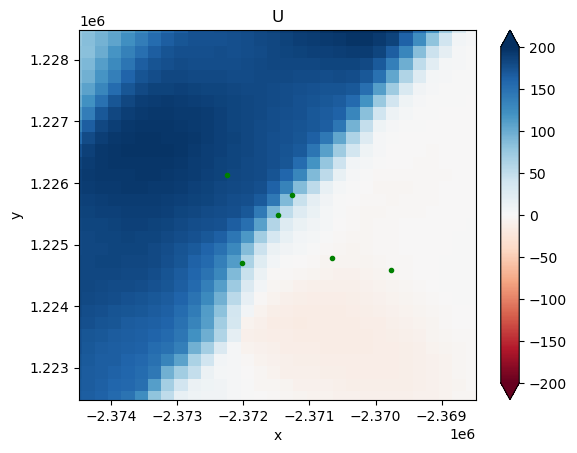

In [155]:
L = 3000
max_U = 200

U.squeeze().plot.imshow(vmax=max_U, vmin=-max_U, cmap='RdBu', xlim=[mid_point_old[0]-L, mid_point_old[0]+L], ylim=[mid_point_old[1]-L, mid_point_old[1]+L])
for site in gdf.index:
    p = point(site)
    plt.plot(p[0], p[1], 'g.')
plt.plot(mid_point_old[0], mid_point_old[1], 'g.')
#plt.plot(mid_point_sites23[0], mid_point_sites23[1], 'bo')
plt.title('U')

## interpolate the U and V at the sites

In [15]:
U_sites = [U.interp(x=[point(site)[0]], y=[point(site)[1]], method='nearest').item() for site in gdf.index]
V_sites = [V.interp(x=[point(site)[0]], y=[point(site)[1]], method='nearest').item() for site in gdf.index]
V_sites

[8.209331512451172,
 4.872355937957764,
 26.950912475585938,
 141.81680297851562,
 126.86125946044922,
 192.61671447753906]

## add U and V values to the gdf|

In [48]:
gdf['U'] = U_sites
gdf['V'] = V_sites
gdf

,Lat,Long,Elevation,geometry,U,V,newX,newY
Site,,,,,,,,
Camp,-65.811924,-62.714833,450,POINT (-2369597.908 1222263.908),-8.276821,8.209332,-2.369606e+06,1.222272e+06
Rock site,-65.801193,-62.672086,444,POINT (-2369766.883 1224590.358),-3.655704,4.872356,-2.369771e+06,1.224595e+06
Site 1,-65.793503,-62.677287,381,POINT (-2370653.103 1224775.687),-4.738622,26.950912,-2.370658e+06,1.224803e+06
Site 2,-65.783112,-62.692062,395,POINT (-2372016.453 1224705.207),62.652687,141.816803,-2.371954e+06,1.224847e+06
Site 3,-65.784583,-62.663775,395,POINT (-2371263.208 1225799.437),88.493744,126.861259,-2.371175e+06,1.225926e+06
Site 4,-65.775563,-62.667177,395,POINT (-2372245.118 1226128.553),184.831818,192.616714,-2.372060e+06,1.226321e+06


## compute new locations

In [17]:
newX = [point(site)[0] + gdf.loc[site, 'U'] for site in gdf.index]
gdf['newX'] = newX
newY = [point(site)[1] + gdf.loc[site, 'V'] for site in gdf.index]
gdf['newY'] = newY
gdf

,Lat,Long,Elevation,geometry,U,V,newX,newY
Site,,,,,,,,
Camp,-65.811924,-62.714833,450,POINT (-2369597.908 1222263.908),-8.276821,8.209332,-2.369606e+06,1.222272e+06
Rock site,-65.801193,-62.672086,444,POINT (-2369766.883 1224590.358),-3.655704,4.872356,-2.369771e+06,1.224595e+06
Site 1,-65.793503,-62.677287,381,POINT (-2370653.103 1224775.687),-4.738622,26.950912,-2.370658e+06,1.224803e+06
Site 2,-65.783112,-62.692062,395,POINT (-2372016.453 1224705.207),62.652687,141.816803,-2.371954e+06,1.224847e+06
Site 3,-65.784583,-62.663775,395,POINT (-2371263.208 1225799.437),88.493744,126.861259,-2.371175e+06,1.225926e+06
Site 4,-65.775563,-62.667177,395,POINT (-2372245.118 1226128.553),184.831818,192.616714,-2.372060e+06,1.226321e+06


## Create a new gdf with the new locations

In [95]:
# create new gdf with newX and newY as geometry
gdf_new = gdf.copy()
# drop lat and lon
gdf_new.drop(columns=['Lat', 'Long'], inplace=True)
gdf_new['geometry'] = gpd.points_from_xy(gdf_new['newX'], gdf_new['newY'])
gdf_new

,Elevation,geometry,U,V,newX,newY
Site,,,,,,
Camp,450,POINT (-2369606.185 1222272.118),-8.276821,8.209332,-2.369606e+06,1.222272e+06
Rock site,444,POINT (-2369770.539 1224595.23),-3.655704,4.872356,-2.369771e+06,1.224595e+06
Site 1,381,POINT (-2370657.841 1224802.638),-4.738622,26.950912,-2.370658e+06,1.224803e+06
Site 2,395,POINT (-2371953.8 1224847.024),62.652687,141.816803,-2.371954e+06,1.224847e+06
Site 3,395,POINT (-2371174.714 1225926.298),88.493744,126.861259,-2.371175e+06,1.225926e+06
Site 4,395,POINT (-2372060.286 1226321.17),184.831818,192.616714,-2.372060e+06,1.226321e+06


In [51]:
def point_new(site):
    return (gdf_new.loc[site].geometry.x, gdf_new.loc[site].geometry.y)

mid_point_new = line_intersection(point_new('Site 1'), point_new('Site 4'), point_new('Site 2'), point_new('Site 3'))


In [52]:
mid_point_sites23_new = (point_new('Site 2')[0] + (point_new('Site 3')[0]-point_new('Site 2')[0])/2, point_new('Site 2')[1] + (point_new('Site 3')[1]-point_new('Site 2')[1])/2)
mid_point_sites23_new

(-2371564.257186706, 1225386.66117485)

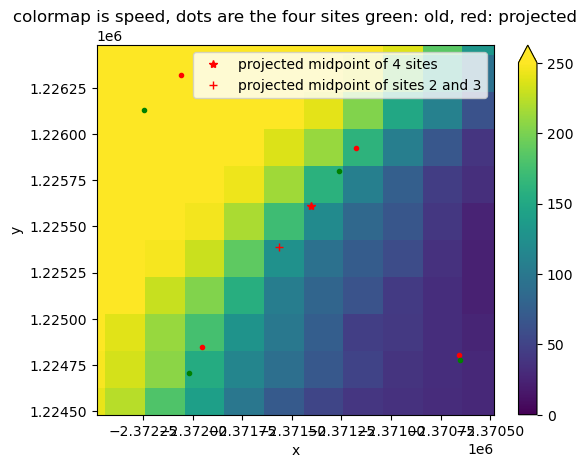

In [160]:
L = 1000
max_U = 250
V = rioxarray.open_rasterio('/Users/jkingslake/Documents/projects/current_projects/AntPen_NSF_NERC/remote sensing/velocities/multiyear/20141125_20250805/S_median_20141125_20250805_200m_timefiltered.tif')
V.squeeze().plot.imshow(vmax=max_U, vmin=0, xlim=[mid_point_old[0]-L, mid_point_old[0]+L], ylim=[mid_point_old[1]-L, mid_point_old[1]+L])
for site in gdf.index:

    plt.plot(point_new(site)[0], point_new(site)[1], 'r.')


    plt.plot(point(site)[0], point(site)[1], 'g.')

#plt.plot(mid_point_old[0], mid_point_old[1], 'g*', label='old midpoint of 4 sites')
plt.plot(mid_point_new[0], mid_point_new[1], 'r*', label='projected midpoint of 4 sites')
plt.plot(mid_point_sites23_new[0], mid_point_sites23_new[1], 'r+', label='projected midpoint of sites 2 and 3')
plt.title('colormap is speed, dots are the four sites green: old, red: projected')
plt.legend()

In [97]:
## add row to gdf_new for mid_point_new
gdf_new.loc['mid_point_new'] = [0,0,0,0,mid_point_new[0], mid_point_new[1]]
gdf_new.loc['mid_point_sites23_new'] = [0,0,0,0,mid_point_sites23_new[0], mid_point_sites23_new[1]]
gdf_new['geometry'] = gpd.points_from_xy(gdf_new['newX'], gdf_new['newY'])
gdf_new.set_crs(epsg=3031, inplace=True)

gdf_new.crs


<Projected CRS: EPSG:3031>
Name: WGS 84 / Antarctic Polar Stereographic
Axis Info [cartesian]:
- E[north]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Antarctica.
- bounds: (-180.0, -90.0, 180.0, -60.0)
Coordinate Operation:
- name: Antarctic Polar Stereographic
- method: Polar Stereographic (variant B)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [101]:
gdf_wgs = gdf_new.copy()
gdf_wgs.to_crs(epsg=4326, inplace=True)
gdf_wgs

,Elevation,geometry,U,V,newX,newY
Site,,,,,,
Camp,450.0,POINT (-62.71476 -65.81183),-8.276821,8.209332,-2.369606e+06,1.222272e+06
Rock site,444.0,POINT (-62.67203 -65.80114),-3.655704,4.872356,-2.369771e+06,1.224595e+06
Site 1,381.0,POINT (-62.67682 -65.79336),-4.738622,26.950912,-2.370658e+06,1.224803e+06
Site 2,395.0,POINT (-62.68874 -65.78303),62.652687,141.816803,-2.371954e+06,1.224847e+06
Site 3,395.0,POINT (-62.66048 -65.78476),88.493744,126.861259,-2.371175e+06,1.225926e+06
Site 4,395.0,POINT (-62.66168 -65.77623),184.831818,192.616714,-2.372060e+06,1.226321e+06
mid_point_new,0.0,POINT (-62.66877 -65.78425),0.000000,0.000000,-2.371403e+06,1.225610e+06
mid_point_sites23_new,0.0,POINT (-62.67461 -65.7839),0.000000,0.000000,-2.371564e+06,1.225387e+06


In [102]:
gdf_wgs.to_file("/Users/jkingslake/Documents/projects/current_projects/AntPen_NSF_NERC/fieldwork/recce_planning_oct25/sites_moved.shp")

In [139]:
gdf_for_sharing = gdf_wgs.copy()
# change names from new X to X, newY to Y
gdf_for_sharing.rename(columns={'newX':'X (updated)', 
                                'newY':'Y (updated)'}, index={ 'mid_point_new': 'midpoint of four sites',
                                'mid_point_sites23_new': 'midpoint of sites 2 and 3'}, inplace=True)
gdf_for_sharing.drop(columns=['U', 'V', 'Elevation'], inplace=True)
# add cols for lat and log
gdf_for_sharing['lat (updated)'] = gdf_for_sharing.geometry.y
gdf_for_sharing['lon (updated)'] = gdf_for_sharing.geometry.x
gdf_for_sharing.drop(columns=['geometry'], inplace=True)

gdf_for_sharing

,X (updated),Y (updated),lat (updated),lon (updated)
Site,,,,
Camp,-2.369606e+06,1.222272e+06,-65.811826,-62.714758
Rock site,-2.369771e+06,1.224595e+06,-65.801145,-62.672029
Site 1,-2.370658e+06,1.224803e+06,-65.793357,-62.676819
Site 2,-2.371954e+06,1.224847e+06,-65.783029,-62.688740
Site 3,-2.371175e+06,1.225926e+06,-65.784763,-62.660484
Site 4,-2.372060e+06,1.226321e+06,-65.776231,-62.661684
midpoint of four sites,-2.371403e+06,1.225610e+06,-65.784255,-62.668772
midpoint of sites 2 and 3,-2.371564e+06,1.225387e+06,-65.783896,-62.674613


In [133]:
gdf_for_sharing.to_excel("/Users/jkingslake/Documents/projects/current_projects/AntPen_NSF_NERC/fieldwork/recce_planning_oct25/sites_moved.xlsx")

In [136]:
gdf_recce_line = gpd.read_file("/Users/jkingslake/Documents/projects/current_projects/AntPen_NSF_NERC/fieldwork/recce_planning_oct25/recce_points_2.shp")

In [138]:

gdf_recce_line['lat (updated)'] = gdf_recce_line.geometry.y
gdf_recce_line['lon (updated)'] = gdf_recce_line.geometry.x
gdf_recce_line

,id,geometry,lat (updated),lon (updated)
0,0,POINT (-62.66658 -65.78068),-65.780680,-62.666576
1,1,POINT (-62.64755 -65.78144),-65.781437,-62.647551
